# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.config import change_settings
change_settings({"FFMPEG_BINARY": "ffmpeg"})
%matplotlib inline

## Helper Functions

In [2]:
def region_of_interest(img, vertices):
    """
    Only keeps the region of img defined by the polygon formed from `vertices`.
    `Vertices` should be a numpy array of integer points.
    The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    2 lines with 'color' and 'thickness' are drawn over the img.
    The lines are linear fit to the ends of the two groups of line segments.
    """
    ## separate lines into 2 groups by slope
    lines1, lines2 = [], []
    for line in lines:
        ## calculate the slope
        line = line[0,:]
        dely = line[3] - line[1]
        delx = line[2] - line[0]
        sl = dely/delx
        ## classify the lines into one of the two groups
        if (sl > -0.3 and sl < 0.3) or sl<-1.2 or sl>1.2:
            continue
        elif sl<0:
            lines1.append(line)
        else:
            lines2.append(line)
    lines1, lines2 = np.array(lines1), np.array(lines2)

    ## fit the lines with linear function
    points1x = lines1[:,0::2].flatten()
    points1y = lines1[:,1::2].flatten()
    points2x = lines2[:,0::2].flatten()
    points2y = lines2[:,1::2].flatten()
    slope1, intercept1 = np.polyfit(points1x, points1y, 1)
    slope2, intercept2 = np.polyfit(points2x, points2y, 1)

    ## generate end points for the linear fit
    img_size_x, img_size_y = img.shape[1], img.shape[0]
    final_line1 = np.array([(img_size_y - intercept1)/slope1, img_size_y, (img_size_y*0.6 - intercept1)/slope1, img_size_y*0.6], dtype=int)
    final_line2 = np.array([(img_size_y - intercept2)/slope2, img_size_y, (img_size_y*0.6 - intercept2)/slope2, img_size_y*0.6], dtype=int)
    final_lines = [final_line1, final_line2]

    ## draw the linear fit an empty image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for x1,y1,x2,y2 in final_lines:
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

    ## superimpose the lines with original image and return the result
    return cv2.addWeighted(line_img, 0.5, img, 1., 0)

def process_image(image):
    Y_size, X_size = image.shape[:2]
    # smooth the image with Gaussian kernel
    kernel_size = 3
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    # convert the image into greyscale
    grey_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)
    # detect the edges via Canny algorithms
    low_threshold, high_threshold = 50, 150
    edges = cv2.Canny(grey_image, low_threshold, high_threshold)
    # only keep the part of the image with the lane
    vertices = np.array( [[[ X_size*0.98, Y_size],[ X_size*0.55, Y_size*0.6],[X_size*0.45,Y_size*0.6],[ X_size*0.1, Y_size]]], dtype=np.int32)
    edges = region_of_interest(edges, vertices)
    # extract feature lines from edges
    rho, theta, line_threshold, min_line_len, max_line_gap =1, np.pi/180, 30, 10, 3
    lines = cv2.HoughLinesP(edges, rho, theta, line_threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # draw two linear fits of the extracted features
    result = draw_lines(image, lines)
    return result

## Build a Lane Finding Pipeline. Test on images.


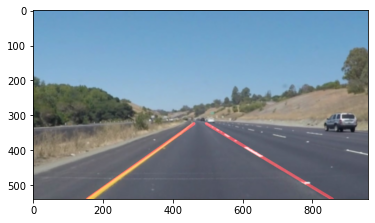

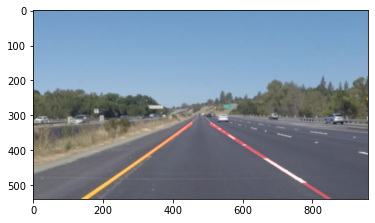

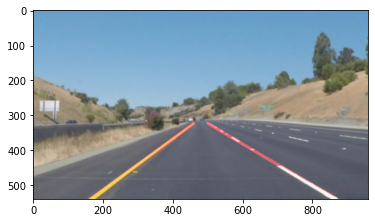

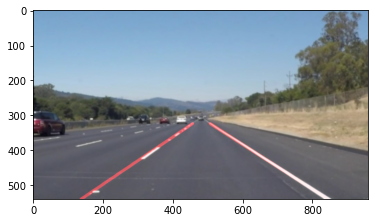

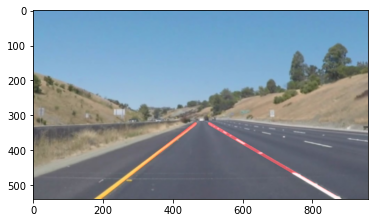

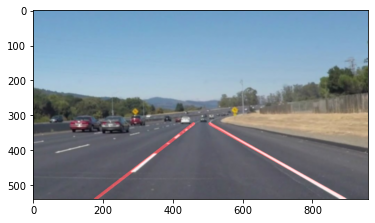

In [3]:
## path to the folder with images
path = "test_images/"
image_files = os.listdir(path)
for image_file in image_files:
    if image_file == '.DS_Store':
        continue
    # load a test image
    current_image = cv2.imread(path+image_file)
    current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)
    Y_size, X_size = current_image.shape[:2]
    # smooth the image with Gaussian kernel
    kernel_size = 5
    current_image = cv2.GaussianBlur(current_image, (kernel_size, kernel_size), 0)
    # convert the image into greyscale
    grey_image = cv2.cvtColor(current_image, cv2.COLOR_RGB2GRAY)
    # detect edges via Canny algorithms
    low_threshold, high_threshold = 50, 150
    edges = cv2.Canny(grey_image, low_threshold, high_threshold)
    # only keep the part of the image with the lane
    vertices = np.array( [[[ X_size*0.98, Y_size],[ X_size*0.55, Y_size*0.6],[X_size*0.45,Y_size*0.6],[ X_size*0.1, Y_size]]], dtype=np.int32 )
    edges = region_of_interest(edges, vertices)
    # extract line features from edges
    rho, theta, line_threshold, min_line_len, max_line_gap =1, np.pi/180, 30, 4, 0
    lines = cv2.HoughLinesP(edges, rho, theta, line_threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # draw two linear fits of the extracted features
    current_image = draw_lines(current_image, lines)
    ## show result
    plt.imshow(current_image)
    plt.show()

## Test on videos



In [4]:
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_output = 'test_videos_output/solidWhiteRight.mp4'
%time white_clip.write_videofile(white_output, audio=False)

t:   7%|▋         | 16/221 [00:00<00:01, 154.12it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.76 s, sys: 344 ms, total: 2.11 s
Wall time: 2.12 s


In [5]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [6]:
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 15/681 [00:00<00:04, 144.19it/s, now=None]Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 5.83 s, sys: 1.05 s, total: 6.89 s
Wall time: 5.99 s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))